# Проект №3. О вкусной и здоровой пище 
**[DSPR-60] SF Predict TripAdvisor Rating Matsera Maxim**

## В этом соревновании нам предстоит предсказать рейтинг ресторана в TripAdvisor
**По ходу задачи:**
* Прокачаем работу с pandas
* Научимся работать с Kaggle Notebooks
* Поймем как делать предобработку различных данных
* Научимся работать с пропущенными данными (Nan)
* Познакомимся с различными видами кодирования признаков
* Немного попробуем [Feature Engineering](https://ru.wikipedia.org/wiki/Конструирование_признаков) (генерировать новые признаки)
* И совсем немного затронем ML
* И многое другое...   

# 1. Import

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import pandas as pd
import numpy as np 
import json
import datetime as dt

import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
import itertools
%matplotlib inline

# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели
# Загружаем специальный инструмент для разбивки:
from sklearn.model_selection import train_test_split

import os
for dirname, _, filenames in os.walk('/kaggle'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

In [2]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

In [3]:
# Для воспроизводимости результатов зададим:
# - общий параметр для генерации случайных чисел
RANDOM_SEED = 42
# - общую текущую дату
CURRENT_DATE = pd.to_datetime('20/11/2020')


# 2. DATA

In [4]:
DATA_DIR = './kaggle/input/sf-dst-restaurant-rating/'
df_train = pd.read_csv(DATA_DIR+'main_task.csv')
# Путь к датасету для которого требуется предсказать рейтинг
df_test = pd.read_csv(DATA_DIR+'kaggle_task.csv')
#Путь к 'submission.csv'
sample_submission = pd.read_csv(DATA_DIR+'sample_submission.csv')

In [5]:
#Датасет, содержащий данные о городах
df_city = pd.read_csv("./kaggle/input/world-cities/worldcities.csv")
df_city.head()

,city,city_ascii,lat,lng,country,iso2,iso3,admin_name,capital,population,id
0,Tokyo,Tokyo,35.6897,139.6922,Japan,JP,JPN,Tōkyō,primary,37977000.0,1392685764
1,Jakarta,Jakarta,-6.2146,106.8451,Indonesia,ID,IDN,Jakarta,primary,34540000.0,1360771077
2,Delhi,Delhi,28.6600,77.2300,India,IN,IND,Delhi,admin,29617000.0,1356872604
3,Mumbai,Mumbai,18.9667,72.8333,India,IN,IND,Mahārāshtra,admin,23355000.0,1356226629
4,Manila,Manila,14.6000,120.9833,Philippines,PH,PHL,Manila,primary,23088000.0,1608618140


In [6]:
# Путь к датасету, содержащему слова с позитивной окраской
df_pos_words = pd.read_table("./kaggle/input/opinion-lexicon/opinion_lexicon/positive-words.txt", comment=';', header=None)
# Путь к датасету, содержащему слова с негативной окраской
df_neg_words = pd.read_table("./kaggle/input/opinion-lexicon/opinion_lexicon/negative-words.txt", comment=';', header=None)
pos_words_list = df_pos_words[0].to_list()
neg_words_list = df_neg_words[0].to_list()

# 3. FUNC

In [7]:
def get_season(date):
   '''
   Время года из даты
   '''
   if (pd.isna(date)):
       return "OTHER"
   month = date.month
   if (month > 11 or month <= 3):
      return "WINTER"
   elif (month == 4 or month == 5):
      return "SPRING"
   elif (month >=6 and month <= 9):
      return "SUMMER"
   else:
      return "FALL"

In [8]:
def round_of_rating(number):
    """
    Округление рейтинга с точностью до 0.5
    """
    return np.round(number * 2) / 2

In [9]:
def get_Weighed_Rank_RK(row):
    '''
    Вычисление относительной позицию ресторана относительно количества ресторанов в городе
    '''
    Weighed_Rank = row.Ranking / row['Restaurants_Count']
    return Weighed_Rank

In [10]:
def get_Weighed_Rank(CityMinMax:pd.DataFrame ,row):
    '''
    Функция для вычисления относительного положения позиции ресторана в группе по городу
    '''
    city_min = CityMinMax[CityMinMax.City == row.City]['min'].iloc[0]
    city_max = CityMinMax[CityMinMax.City == row.City ]['max'].iloc[0]
    Weighed_Rank = round(1 - (row.Ranking-city_min) / (city_max-city_min),3)
    return Weighed_Rank

In [11]:
def cleanup_string(str_in):
    '''
    Чистим текст в review для последующй десериализации
    '''
    try:      
        #middle
        str = str_in.replace("', \"","⅞").replace("', '","⅞").replace("\", '","⅞").replace("\", \"","⅞")# ", 
        str = str.replace("\", \"\"","⅞").replace("\"\", '","⅞").replace("\", \'","⅞").replace("\"\", \'","⅞")
        str = str.replace("\', \'","⅞")
        #left
        str = str.replace("[['","≤").replace("['","⅛")
        #right
        str = str.replace("']]","≥").replace("']","⅝")
        #cleanups
        str = str.replace('\'', ' ').replace('\"', ' ').replace('\'', ' ').replace('"', ' ')     
        str = str.replace("\\", " ").replace("[[`", "≤").replace('\'"', '\'').replace('\'\"', '\'')
        str = str.replace('"\'', '\'').replace('\"\'', '\'').replace("[''" ,"≤").replace("[\'\'" ,"≤")
        str = str.replace('\'', ' ').replace('\"', ' ')
        str = str.replace('\'', ' ').replace('\"', ' ')
        str = str.replace('\'', ' ').replace('"', ' ')
        #middle
        str = str.replace("⅞", "', '")
        #left
        str = str.replace("≤", "[['").replace("⅛", "['").replace('[[ ', '[[ \'')
        #right
        str = str.replace("≥" ,"']]").replace("⅝", "']").replace(' ]', ' \']')
        str = str.replace(', nan]', '\', \'nan\']').replace('[nan, ', '[\'nan\', \'')
    except Exception:
        print('<----',str_in,'---->')
    return str

In [12]:
def get_reviews(rev):
    '''
    Получаем review в виде:
    review['reviews_txt'][1] - list of reviews
    review['reviews_dt'][1] - list of reviews dates
    '''
    if  not pd.isna(rev): 
        #Преобразование к формату json для удобного парсинга
        rev = str(rev).replace("'",'"')
        rev = rev.replace('], [', '], "reviews_dt": [')
        rev = '{ "reviews_txt":' + rev + '}'
        rev = rev.replace('[[','[').replace(']]',']')
        d = json.loads(rev)

        d['reviews_dt'] = [dt.datetime.strptime(date, '%m/%d/%Y').date() if len(date.split('/')[2])==4 \
            else dt.datetime.strptime(date, '%m/%d/%y').date() for date in d['reviews_dt']]
        return d
    else:
        return {}

In [13]:
def rev_time_delta(rev):
    '''
    Вычисляем время между review в днях
    '''
    if (pd.notna(rev)):
        reviews_dt_list = get_reviews(rev)['reviews_dt']
        if reviews_dt_list:
            return (max(reviews_dt_list) - min(reviews_dt_list)).days
        else:
            return dt.timedelta(days=3650).days
    else:
        return dt.timedelta(days=3650).days

In [14]:
def get_cuisines(cuisines):
    '''
    Получаем список кухонь в виде:
    cuisines[0] - list of cusines
    если был NaN, то возвращается 'Regional Cusine' -как самая популярная в регионе/городе/стране
    '''
    if cuisines == 'NaN': return ['Regional Cusine']
    if  cuisines:
        cuisines = str(cuisines).replace("'",'"')
        return json.loads(cuisines)
    else:
        return ['Regional Cusine']

In [15]:
allCusines = []
def cuisine_styles_count(row):
    '''
    Получаем количество кухонь
    '''
    global allCusines
    cusines = get_cuisines(row['Cuisine_Style'])
    
    if row['Cuisine_Style'] != 'NaN':    
        cusines = get_cuisines(row['Cuisine_Style'])
        allCusines.extend(cusines)
        cuisines_count =len(cusines)
    else:
        cuisines_count = 1

    return cuisines_count

In [16]:
def get_city_population_and_country(df:pd.DataFrame, df_city:pd.DataFrame):
    '''
    Получаем популяцию по городам, а так же ISO код страны по городу (из внешних источников)
    '''
    population_city_dict = {}
    country_city_dict = {}
    cities = df['City'].unique()

    for city in cities:
    
        vals = (df_city[df_city.city.str.contains(city)].population / 1000000).max()
        vals = 0.3 if np.isnan(vals) else vals
    
        population_city_dict[city] = vals
        country =  df_city[df_city.city.str.contains(city)][df_city[df_city.city.str.contains(city)].population == df_city[df_city.city.str.contains(city)].population.max()].iso2
        country = -1 if country.shape[0] < 1 else country.keys()[0]
        country_city_dict[city] = country

    population_city_dict['Luxembourg'] = 0.613894 
    population_city_dict['Brussels'] = 2.115468 
    population_city_dict['Geneva'] = 0.686562 
    population_city_dict['Oporto'] = 0.214349 
    population_city_dict['Ljubljana'] = 0.279631



    country_city_dict['Luxembourg'] = 442 
    country_city_dict['Brussels'] = 56 
    country_city_dict['Geneva'] = 756 
    country_city_dict['Oporto'] = 620 
    country_city_dict['Ljubljana'] = 705
    
    #Эти данные корректнее
    population_city_dict = {    'London': 8.173900,
    'Paris': 2.240621,
    'Madrid': 3.155360,
    'Barcelona': 1.593075,
    'Berlin': 3.326002,
    'Milan': 1.331586,
    'Rome': 2.870493,
    'Prague': 1.272690,
    'Lisbon': .547733,
    'Vienna': 1.765649,
    'Amsterdam': .825080,
    'Brussels': .144784,
    'Hamburg': 1.718187,
    'Munich': 1.364920,
    'Lyon': .496343,
    'Stockholm': 1.981263,
    'Budapest': 1.744665,
    'Warsaw': 1.720398,
    'Dublin': .506211 ,
    'Copenhagen': 1.246611,
    'Athens': 3.168846,
    'Edinburgh': .476100,
    'Zurich': .402275,
    'Oporto': .221800,
    'Geneva': .196150,
    'Krakow': .756183,
    'Oslo': .673469,
    'Helsinki': .574579,
    'Bratislava': .413192,
    'Luxembourg': .576249,
    'Ljubljana': .277554
    }
    return population_city_dict, country_city_dict

In [17]:
def get_capital_city_dict(df_in:pd.DataFrame, df_city:pd.DataFrame):
    '''
    Возвращаем словарь город == столица или нет
    '''
    capital_city_dict = {}
    cities = df_in['City'].unique()

    df_city['isCapital'] = df_city.capital.apply(lambda x: True if x == "primary" else False)

    for city in cities:
        vals = df_city[df_city.city.str.contains(city)] \
            [df_city[df_city.city.str.contains(city)].population == df_city[df_city.city.str.contains(city)].population.max()].isCapital
        capital_city_dict[city] = vals.values[0] if len(vals) > 0 else False
    return capital_city_dict

In [18]:
def is_cuisine_top_N(cs):
    '''
    Возвращаем список кухонь, входящих в основной список кухонь,для остальных Other
    '''
    c = get_cuisines(cs)
    c = set(c)

    shared_cousines=()
    shared_cousines=c.intersection(topNcusines)

    if len(shared_cousines) != len(c):
        shared_cousines = list(shared_cousines)
        shared_cousines.extend(['Other'])

    return list(shared_cousines)

In [19]:
def createWordList(line):
    wordList2 =[]
    wordList1 = line.split()
    for word in wordList1:
        cleanWord = ""
        for char in word:
            if char in '!,.?":;0123456789':
                char = ""
            cleanWord += char
        wordList2.append(cleanWord.lower())
    return wordList2

In [20]:
def count_positive_words_proportion(reviews):
    '''
    Количество позитивных слов в приведенных отзывах
    '''
    pos_words_count = 0
    txts=get_reviews(reviews)['reviews_txt']
    txt = ' '.join(txts)
    #print(type(txt))
    words = createWordList(txt)
    
    words_count = len(words) if len(words) > 0 else 1
    words_count = 1
    for word in words:
        if word in pos_words_list:
            #print(word)
            pos_words_count +=1  
    return np.round(pos_words_count / words_count,2)

def count_negative_words_proportion(reviews):
    '''
    Количество негативных слов в приведенных отзывах
    '''
    neg_words_count = 0
    txts=get_reviews(reviews)['reviews_txt']
    txt = ' '.join(txts)
    #print(type(txt))
    words = createWordList(txt)
    
    words_count = len(words) if len(words) > 0 else 1
    words_count = 1
    for word in words:
        if word in neg_words_list:
            #print(word)
            neg_words_count +=1  
    return np.round(neg_words_count / words_count,2)

def list_positive_words(reviews): 
    '''
    Список уникальных позитивных слов в приведенных отзывах
    '''
    txts = get_reviews(reviews)['reviews_txt']
    txt = ' '.join(txts)
    words = createWordList(txt)
    
    words_count = len(words) if len(words) > 0 else 1
    words_count = 1
    pos_words_in_review=set(words).intersection(pos_words_list)
    if (len(pos_words_in_review) == 0):
        return np.NAN
    else:
        return list(pos_words_in_review)

def list_negative_words(reviews): 
    '''
    Список уникальных негативных слов в приведенных отзывах
    '''
    txts = get_reviews(reviews)['reviews_txt']
    txt = ' '.join(txts)
    words = createWordList(txt)
    
    words_count = len(words) if len(words) > 0 else 1
    words_count = 1
    neg_words_in_review=set(words).intersection(neg_words_list)
    if (len(neg_words_in_review) == 0):
        return np.NAN
    else:
        return list(neg_words_in_review) 

# 4. Data Info

In [21]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      40000 non-null  object 
 1   City               40000 non-null  object 
 2   Cuisine Style      30717 non-null  object 
 3   Ranking            40000 non-null  float64
 4   Rating             40000 non-null  float64
 5   Price Range        26114 non-null  object 
 6   Number of Reviews  37457 non-null  float64
 7   Reviews            40000 non-null  object 
 8   URL_TA             40000 non-null  object 
 9   ID_TA              40000 non-null  object 
dtypes: float64(3), object(7)
memory usage: 3.1+ MB


In [22]:
df_train.head(5)

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_5569,Paris,"['European', 'French', 'International']",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643
1,id_1535,Stockholm,NaN,1537.0,4.0,NaN,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032
2,id_352,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353.0,4.5,$$$$,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781
3,id_3456,Berlin,NaN,3458.0,5.0,NaN,3.0,"[[], []]",/Restaurant_Review-g187323-d1358776-Reviews-Es...,d1358776
4,id_615,Munich,"['German', 'Central European', 'Vegetarian Fri...",621.0,4.0,$$ - $$$,84.0,"[['Best place to try a Bavarian food', 'Nice b...",/Restaurant_Review-g187309-d6864963-Reviews-Au...,d6864963


In [23]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет

df_train['Train'] = True # помечаем где у нас трейн
df_test['Train'] = False # помечаем где у нас тест
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

In [24]:
data.columns = list(map(lambda x: x.replace(" ","_"), data.columns))
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      50000 non-null  object 
 1   City               50000 non-null  object 
 2   Cuisine_Style      38410 non-null  object 
 3   Ranking            50000 non-null  float64
 4   Price_Range        32639 non-null  object 
 5   Number_of_Reviews  46800 non-null  float64
 6   Reviews            49998 non-null  object 
 7   URL_TA             50000 non-null  object 
 8   ID_TA              50000 non-null  object 
 9   Train              50000 non-null  bool   
 10  Rating             50000 non-null  float64
dtypes: bool(1), float64(3), object(7)
memory usage: 3.9+ MB


Первоначальная версия датасета состоит из десяти столбцов, содержащих следующую информацию:

- **Restaurant_id** — идентификационный номер ресторана / сети ресторанов;
- **City** — город, в котором находится ресторан;
- **Cuisine Style** — кухня или кухни, к которым можно отнести блюда, предлагаемые в ресторане;
- **Ranking** — место, которое занимает данный ресторан среди всех ресторанов своего города;
- **Rating** — рейтинг ресторана по данным TripAdvisor (именно это значение должна будет предсказывать модель);
- **Price Range** — диапазон цен в ресторане;
- **Number of Reviews** — количество отзывов о ресторане;
- **Reviews** — данные о двух отзывах, которые отображаются на сайте ресторана;
- **URL_TA** — URL страницы ресторана на TripAdvisor;
- **ID_TA** — идентификатор ресторана в базе данных TripAdvisor.

In [25]:
# Выбираем нужные для последующего анализа столбцы
df = data.drop('URL_TA',axis=1).copy()

In [26]:
df.head(5)

,Restaurant_id,City,Cuisine_Style,Ranking,Price_Range,Number_of_Reviews,Reviews,ID_TA,Train,Rating
0,id_0,Paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",d10746918,False,0.0
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",d6674944,False,0.0
2,id_2,Edinburgh,['Vegetarian Friendly'],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",d13129638,False,0.0
3,id_3,London,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,$$$$,202.0,"[['Most exquisite', 'Delicious and authentic']...",d680417,False,0.0
4,id_4,Bratislava,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,$$$$,162.0,"[['Always the best in bratislava', 'Very good ...",d1112354,False,0.0


In [27]:
df.Reviews[1]

"[['Very good reviews!', 'Fine dining in Hakaniemi'], ['12/05/2017', '10/29/2017']]"

Как видим, большинство признаков у нас требует очистки и предварительной обработки.

# 5. Обработка NAN и Обработка признаков

**Посмотрим на признаки и к-во пропусков (NaN)**

In [28]:
df.info()
print("\nКоличество пропусков:")
for col in df.columns:
    if data[col].isna().sum() > 0:
        print(col, "\t:", data[col].isna().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      50000 non-null  object 
 1   City               50000 non-null  object 
 2   Cuisine_Style      38410 non-null  object 
 3   Ranking            50000 non-null  float64
 4   Price_Range        32639 non-null  object 
 5   Number_of_Reviews  46800 non-null  float64
 6   Reviews            49998 non-null  object 
 7   ID_TA              50000 non-null  object 
 8   Train              50000 non-null  bool   
 9   Rating             50000 non-null  float64
dtypes: bool(1), float64(3), object(6)
memory usage: 3.5+ MB

Количество пропусков:
Cuisine_Style 	: 11590
Price_Range 	: 17361
Number_of_Reviews 	: 3200
Reviews 	: 2


**Посмотрим на признаки и к-во уникальных значений**

In [29]:
df.nunique(dropna=False)

Restaurant_id        13094
City                    31
Cuisine_Style        10732
Ranking              12975
Price_Range              4
Number_of_Reviews     1574
Reviews              41858
ID_TA                49963
Train                    2
Rating                  10
dtype: int64

**Посмотрим на гистограммы числовых признаков**

In [30]:
df['Train']

0        False
1        False
2        False
3        False
4        False
         ...  
49995     True
49996     True
49997     True
49998     True
49999     True
Name: Train, Length: 50000, dtype: bool

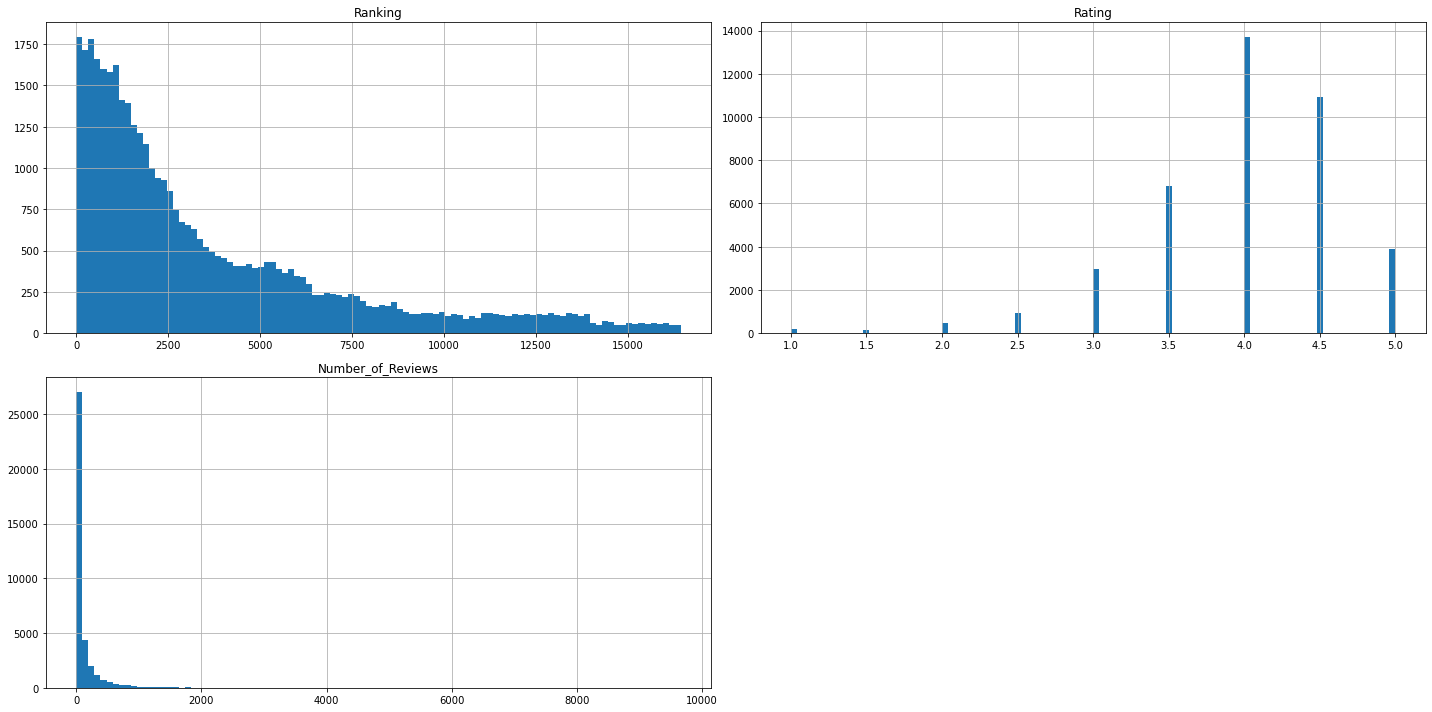

In [31]:
df[df.Train][['Ranking', 'Rating', 'Number_of_Reviews']].hist(figsize=(20, 10), bins=100);
plt.tight_layout()

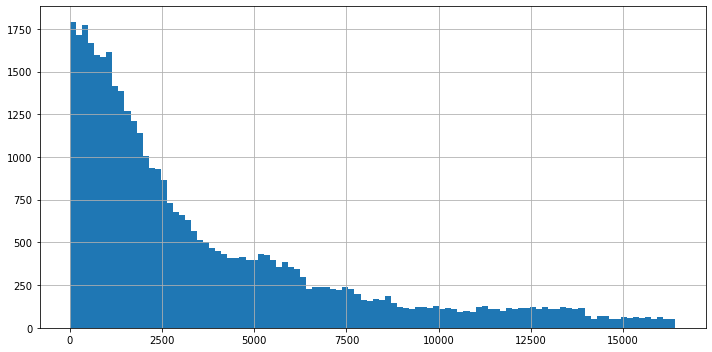

In [32]:
df[df.Train]['Restaurant_id'].apply(lambda x: x.split('_')[1]).astype(int).hist(figsize=(10,5), bins=100)
plt.tight_layout()
# Restaurant_id Очень похож на Ranking

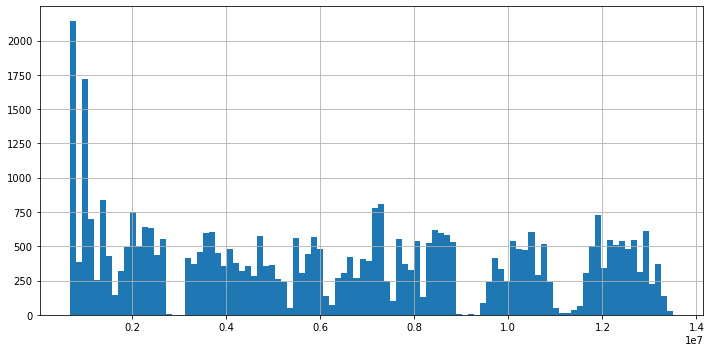

In [33]:
df[df.Train]['ID_TA'].apply(lambda x: x.replace('d','')).astype(int).hist(figsize=(10, 5), bins=100)
plt.tight_layout()
# Видно Несколько групп - на ID - точно не похоже. 

In [34]:
df['ID_TA'] = df['ID_TA'].apply(lambda x: x[1:]).astype(int)

In [35]:
# Reviews - убираем NaN и "причесываем" текст отзывов 
df['Reviews_txt_NaN'] = df['Reviews'].apply(lambda x: x ==  '[[], []]')

df['Reviews'] = df['Reviews'].fillna('[[], []]')
df['Reviews'] = df['Reviews'].apply(lambda x: cleanup_string(x))

In [36]:
# Перекодируем Price Range и удаляем NaN
cleanup_nums = {'Price_Range': {"$": 1, "$$ - $$$": 2, "$$$$": 3, np.NaN: 2}}
# чаще всего встречается "$$ - $$$", поэтому пропуски заменили на 2
df['Price_Range_NaN'] = df['Price_Range'].isna()
df.replace(cleanup_nums, inplace=True)

In [37]:
# Получаем Cuisines Count, самую популярную кухню, среднее к-во кухонь в ресторане и устраняем NaN
df['Cuisine_Style_NAN'] = df['Cuisine_Style'].isna()
df['Cuisine_Style'] = df['Cuisine_Style'].fillna('NaN')
df['Cuisines_Count'] = df.apply(cuisine_styles_count, axis=1)

most_popular_cusine = pd.Series(allCusines).value_counts().index[0]
average_cousines_count = np.round(df['Cuisines_Count'].mean())

In [38]:
# Number of Reviews
df['Number_of_Reviews_NAN'] = df['Number_of_Reviews'].isna()
replace_val = df['Number_of_Reviews'].mean()
replace_val = np.round(replace_val)
df['Number_of_Reviews'] = df['Number_of_Reviews'].fillna(replace_val)

In [39]:
df.sample(5)

,Restaurant_id,City,Cuisine_Style,Ranking,Price_Range,Number_of_Reviews,Reviews,ID_TA,Train,Rating,Reviews_txt_NaN,Price_Range_NaN,Cuisine_Style_NAN,Cuisines_Count,Number_of_Reviews_NAN
46646,id_5967,Madrid,NaN,5970.0,2,124.0,"[[], []]",12957208,True,4.0,True,True,True,1,True
37513,id_1095,Dublin,NaN,1098.0,2,7.0,"[['Fish and chips', 'Fine pizza'], ['07/12/201...",5823091,True,4.5,False,True,True,1,False
49358,id_2530,Amsterdam,['Mediterranean'],2537.0,2,18.0,"[['Very good', 'Delicious Quail'], ['08/26/201...",4339263,True,4.0,False,False,False,1,False
47612,id_3432,Paris,['Chinese'],3433.0,2,40.0,"[['Very good Chinese restaurant in Paris.', 'G...",9468440,True,4.5,False,False,False,1,False
12071,id_939,Geneva,['Japanese'],944.0,2,15.0,"[['Lots of choices', 'Delicious!'], ['12/31/20...",10158397,True,3.5,False,False,False,1,False


# 6. EDA Анализ данных
На этом этапе мы строим графики, ищем закономерности, аномалии, выбросы или связи между признаками.
В общем цель этого этапа понять, что эти данные могут нам дать и как признаки могут быть взаимосвязаны между собой.
Понимание изначальных признаков позволит сгенерировать новые, более сильные и, тем самым, сделать нашу модель лучше.

## 6.1 Распределение признаков

<AxesSubplot:>

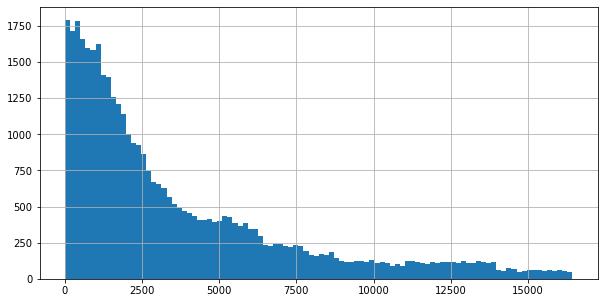

In [40]:
plt.rcParams['figure.figsize'] = (10,5)
df[df.Train]['Ranking'].hist(bins=100)

У нас много ресторанов, которые не дотягивают и до 2500 места в своем городе, а что там по городам?

<AxesSubplot:>

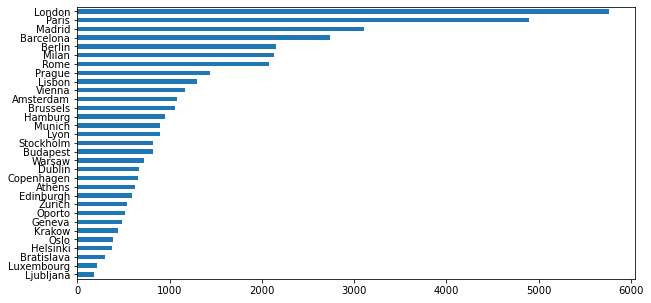

In [41]:
df[df.Train]['City'].value_counts(ascending=True).plot(kind='barh')

<AxesSubplot:>

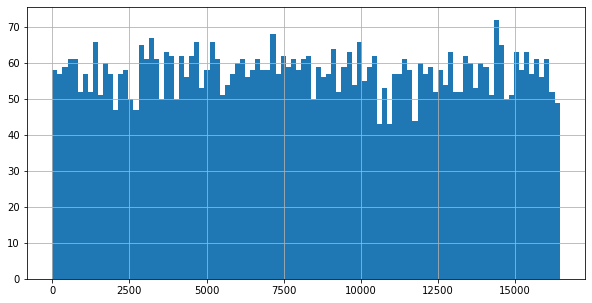

In [42]:
df[df.Train]['Ranking'][df[df.Train]['City'] =='London'].hist(bins=100)

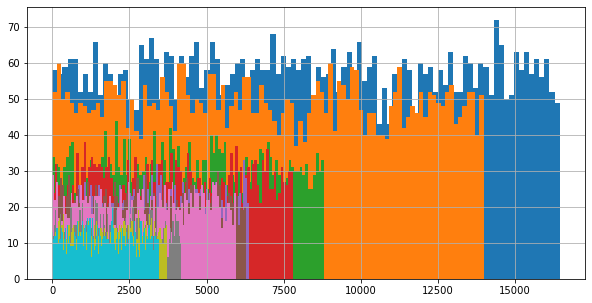

In [43]:
# посмотрим на топ 10 городов
for x in (df[df.Train]['City'].value_counts())[0:10].index:
    df[df.Train]['Ranking'][df[df.Train]['City'] == x].hist(bins=100)
plt.show()

Получается, что Ranking имеет нормальное распределение, просто в больших городах больше ресторанов, из-за мы этого имеем смещение.  
Для устранения смещения нормализуем Ranking, то есть проведём min-max нормализацию признака (Min-Max Scaling)

## 6.2 Распределение целевой переменной

<AxesSubplot:>

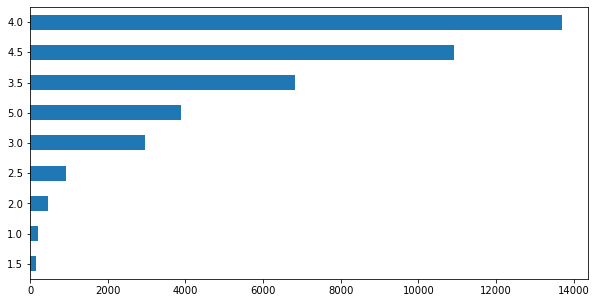

In [44]:
df[df.Train]['Rating'].value_counts(ascending=True).plot(kind='barh')

## 6.3 Посмотрим распределение целевой переменной относительно признака

<AxesSubplot:>

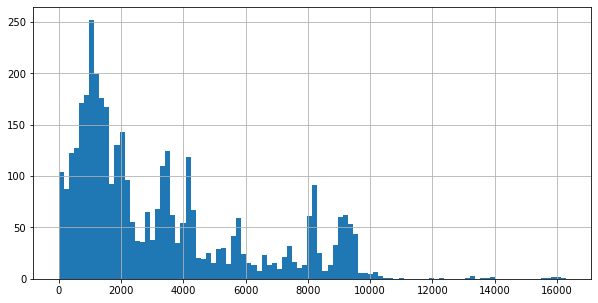

In [45]:
df[df.Train]['Ranking'][df[df.Train]['Rating'] == 5].hist(bins=100)

<AxesSubplot:>

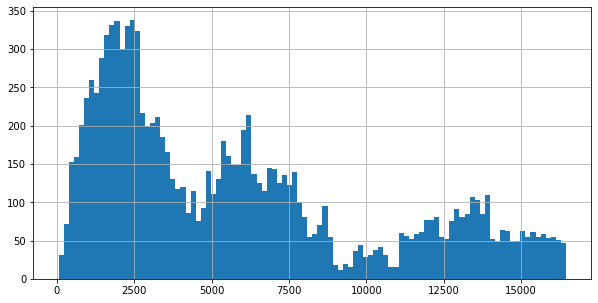

In [46]:
df[df.Train]['Ranking'][df[df.Train]['Rating'] < 4].hist(bins=100)

Рестораны с меньшим рейтингом располагаются на более худших местах в рейтинге по городу, что логично

## 6.4 Корреляция имеющихся признаков

Практически единственным признаком, коррелирующим с Rating является Ranking. Он, в свою очередь, уже имеет слабую корреляцию практически со всеми признаками 

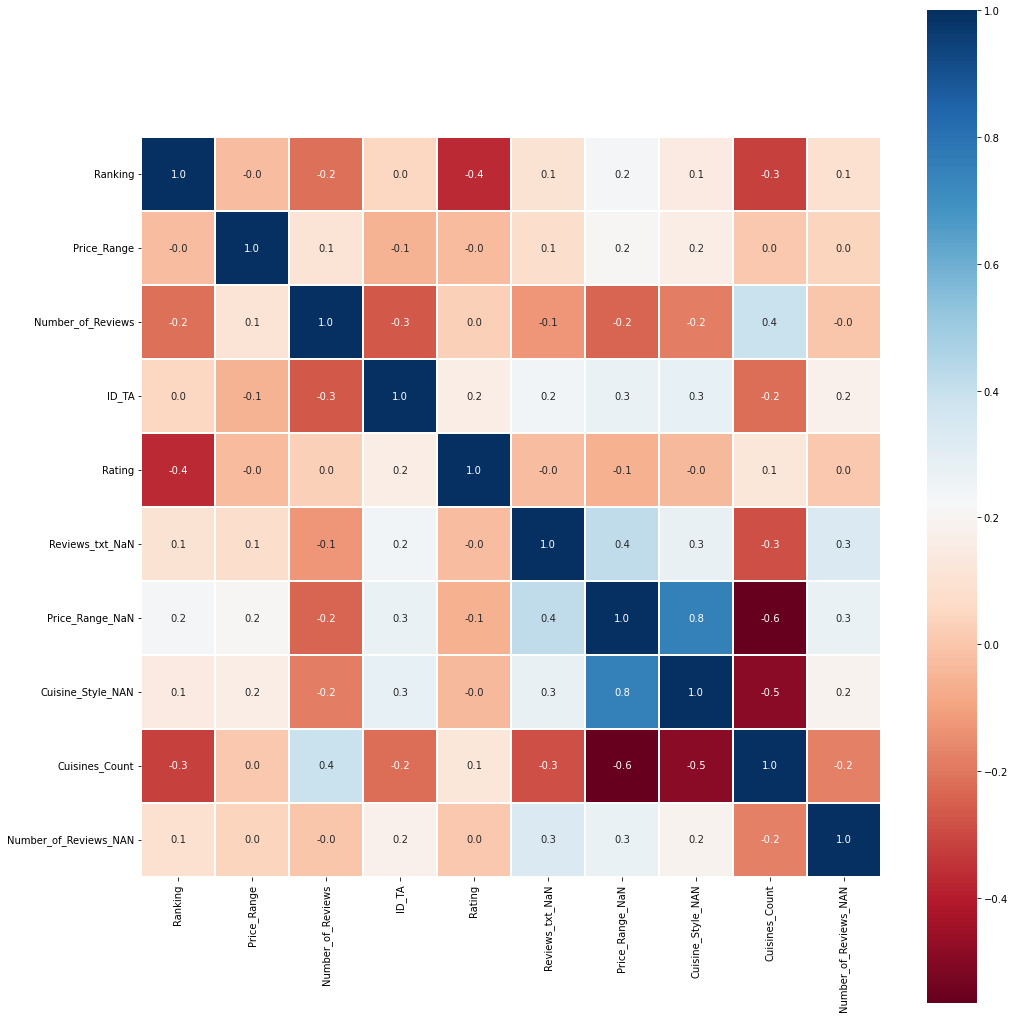

In [47]:
plt.rcParams['figure.figsize'] = (15,15)
sns.heatmap(df[df.Train].drop(['Train'], axis=1).corr(), square=True,
            annot=True, fmt=".1f", linewidths=0.1, cmap="RdBu")
plt.tight_layout()

# 7. Генерация новых признаков (пока без dummies)
Подключаем внешние данные

In [48]:
population_city_dict = {}
country_city_dict = {}
# Получаем словари популяции по городам, а так же ISO код страны по городу
population_city_dict, country_city_dict = get_city_population_and_country(df, df_city)

In [49]:
# Вычисляем страну для города в каждой строке
df['Country'] = df["City"].apply(lambda x: country_city_dict[x])

In [50]:
# Вычисляем к-во ресторанов для города в каждой строке
restorants_in_city = df.groupby('City')['Ranking'].count().to_dict()
df['Restaurants_Count'] = df['City'].map(restorants_in_city)

In [51]:
# Вычисляем население (в тыс. чел) для города в каждой строке
df['Population'] = df["City"].map(population_city_dict)

In [52]:
# Вычисляем к-во ресторанов на 1000 чел для города в каждой строке
df['Restaurants_for_Population'] = df.Restaurants_Count / (df['Population']*1000)

In [53]:
# Вычисляем является ли город столицей в каждой строке
capital_city_dict = get_capital_city_dict(df, df_city)
df['isCapital'] = df["City"].apply(lambda x: capital_city_dict[x])

In [54]:
# Получаем относительную позицию ресторана среди всех ресторанов города
df['Weighed_Rank'] = df.apply(lambda x: get_Weighed_Rank_RK(x), axis=1)

CityMinMax = df.groupby('City')['Ranking'].agg([min,max])
CityMinMax =CityMinMax.reset_index()
df['Weighed_Rank_min_max'] = df.apply(lambda x: get_Weighed_Rank(CityMinMax, x), axis=1)

In [55]:
# Флаги (1/0) isMostPopCusine - есть ли в ресторане самая популярная кухня; isMultyCusine - к-во кухонь в ресторане больше или столько же чем в среднем
df['isMostPopCusine'] = df.Cuisine_Style.apply(lambda x: 1 if most_popular_cusine in x else 0 )
df['isMultyCusine'] = df.Cuisines_Count.apply(lambda x: 1 if  x >= average_cousines_count else 0 )

In [56]:
# RevTimeDelta - время между review в днях
df['RevTimeDelta'] = df.Reviews.apply(rev_time_delta)

In [57]:
# NewestReviewDate - время, прошедшее со момента последнего review
df['NewestReviewDate'] = df.Reviews.apply(lambda x: get_reviews(x)['reviews_dt'])
df['NewestReviewDate'] = df.NewestReviewDate.apply(lambda x: sorted(x,reverse=True)[0] if len(x)!=0 else pd.NaT)
df['NewestReviewDate'] = df.NewestReviewDate.fillna(dt.date(1970,1,1))
df['NewestReviewDate'] = df.NewestReviewDate.apply(lambda x: (CURRENT_DATE.date()-x).total_seconds()//86400)

In [58]:
df['NewestReviewSeason'] = df.Reviews.apply(lambda x: get_reviews(x)['reviews_dt'])
df['NewestReviewSeason'] = df.NewestReviewSeason.apply(lambda x: sorted(x,reverse=True)[0] if len(x)!=0 else pd.NaT)

df['NewestReviewSeason'] = df.NewestReviewSeason.apply(lambda x: get_season(x))

In [59]:
#  'TxtReviewsCount' - к-во отзывов, не сильно улучшает результат, но пусть будут
df['TxtReviewsCount'] = df.Reviews.apply(lambda x: len(get_reviews(x)['reviews_txt']))

In [60]:
# К-во позитивных слов в представленных отзывах
df['PositiveWords'] = df.Reviews.apply(lambda x: count_positive_words_proportion(x))
# Список уникальных позитивных слов в представленных отзывах
df['PositiveWordsList'] = df.Reviews.apply(lambda x: list_positive_words(x))

In [61]:
cusines_in_city={}
cusines_count_in_city={}
for city_name, group in df.groupby('City'):
    #Получим серию со списками кухонь для групп
    cusines = group['Cuisine_Style'].apply(get_cuisines)
    #Получим список кухонь в группе
    cusines_list = list(itertools.chain.from_iterable(cusines))
    #Посчитаем и запишем число совпадений для каждой кухни в каждой группе при помощи Counter
    cusines_in_city[city_name] = Counter(cusines_list)    

for city_name in cusines_in_city.keys():
    cusines_count_in_city[city_name] = len(cusines_in_city[city_name])
  
df['Cusines_Count_In_City'] = df.City.map(cusines_count_in_city)

In [62]:
# Относительная доля кухонь в ресторане
df['Weighed_Cuisines_Count'] = df['Cuisines_Count'] / df['Cusines_Count_In_City']  

In [63]:
# Самая популярная кухня в городе
df['Most_Common_Cusine_in_City'] = df['City'].apply(lambda x: cusines_in_city[x].most_common(1)[0][0])
# Заменим пропуски на самую популярную
df['Cuisine_Style'] = df.apply(lambda x: x['Cuisine_Style'] if x['Cuisine_Style_NAN'] ==False else [x['Most_Common_Cusine_in_City']], axis=1)

In [64]:
# зависимость места ресторана в городе от населения
df['Weighed_Rank_by_Population'] = df['Weighed_Rank']  / df['Population'] 

In [65]:
df['PositiveWords_in_Reviews'] = df['PositiveWords'] / df['Number_of_Reviews']

In [66]:
# Как часто в городе оставляют отзывы
df['NRP'] = df['Number_of_Reviews'] / df['Population']

In [67]:
# Ранг ресторана с учетом частоты отзывов в городе
df['WRR'] =  df['Weighed_Rank']  *  df['NRP'] 
df['Relative_Price_Range'] = df['Price_Range'] / df['Weighed_Rank']

In [68]:
# Средняя цена в городе
price_in_city_dict = df.groupby('City')['Price_Range'].mean().to_dict()
df['Price_in_City'] = df['City'].map(price_in_city_dict)

In [69]:
# Сокращаем список кухонь для анализа до N - основных, остальные Other
N=30 #!!!

s = df['Cuisine_Style'].apply(lambda x: get_cuisines(x))
slist =[]
for x in s:
    slist.extend(x)
topNcusines = set(pd.Series(slist).value_counts()[:N].index)  
df['Cuisine_top_N'] =df['Cuisine_Style'].apply(lambda x: is_cuisine_top_N(x))

In [70]:
# Сетевой ID ресторана (похоже, что это ID франшизы, если повторяется более 1-го раза - isNetworkRestorant)
import warnings; warnings.simplefilter('ignore')
df['Restaurant_net_id'] = df['Restaurant_id'].apply(lambda x: x.split('_')[1])
NetworkRestorants = df[df['Restaurant_net_id'].isin(df['Restaurant_net_id'].value_counts()[df['Restaurant_net_id'].value_counts()>2].index)]
NetworkRestorants['isNetworkRestorant'] = True
df['isNetworkRestorant'] = NetworkRestorants['isNetworkRestorant']
df['isNetworkRestorant'] = df['isNetworkRestorant'].fillna(False)

In [71]:
# Помечаем, входит ли город в N-top городов, если ДА, то пишем его назавние, если НЕТ -Other
top_Cityes = df['City'].value_counts()[0:10].index.to_list()
df['TopCityes'] = df.City.apply(lambda x: x if x in top_Cityes else 'Other_City')

# 8. Отсмотр признаков

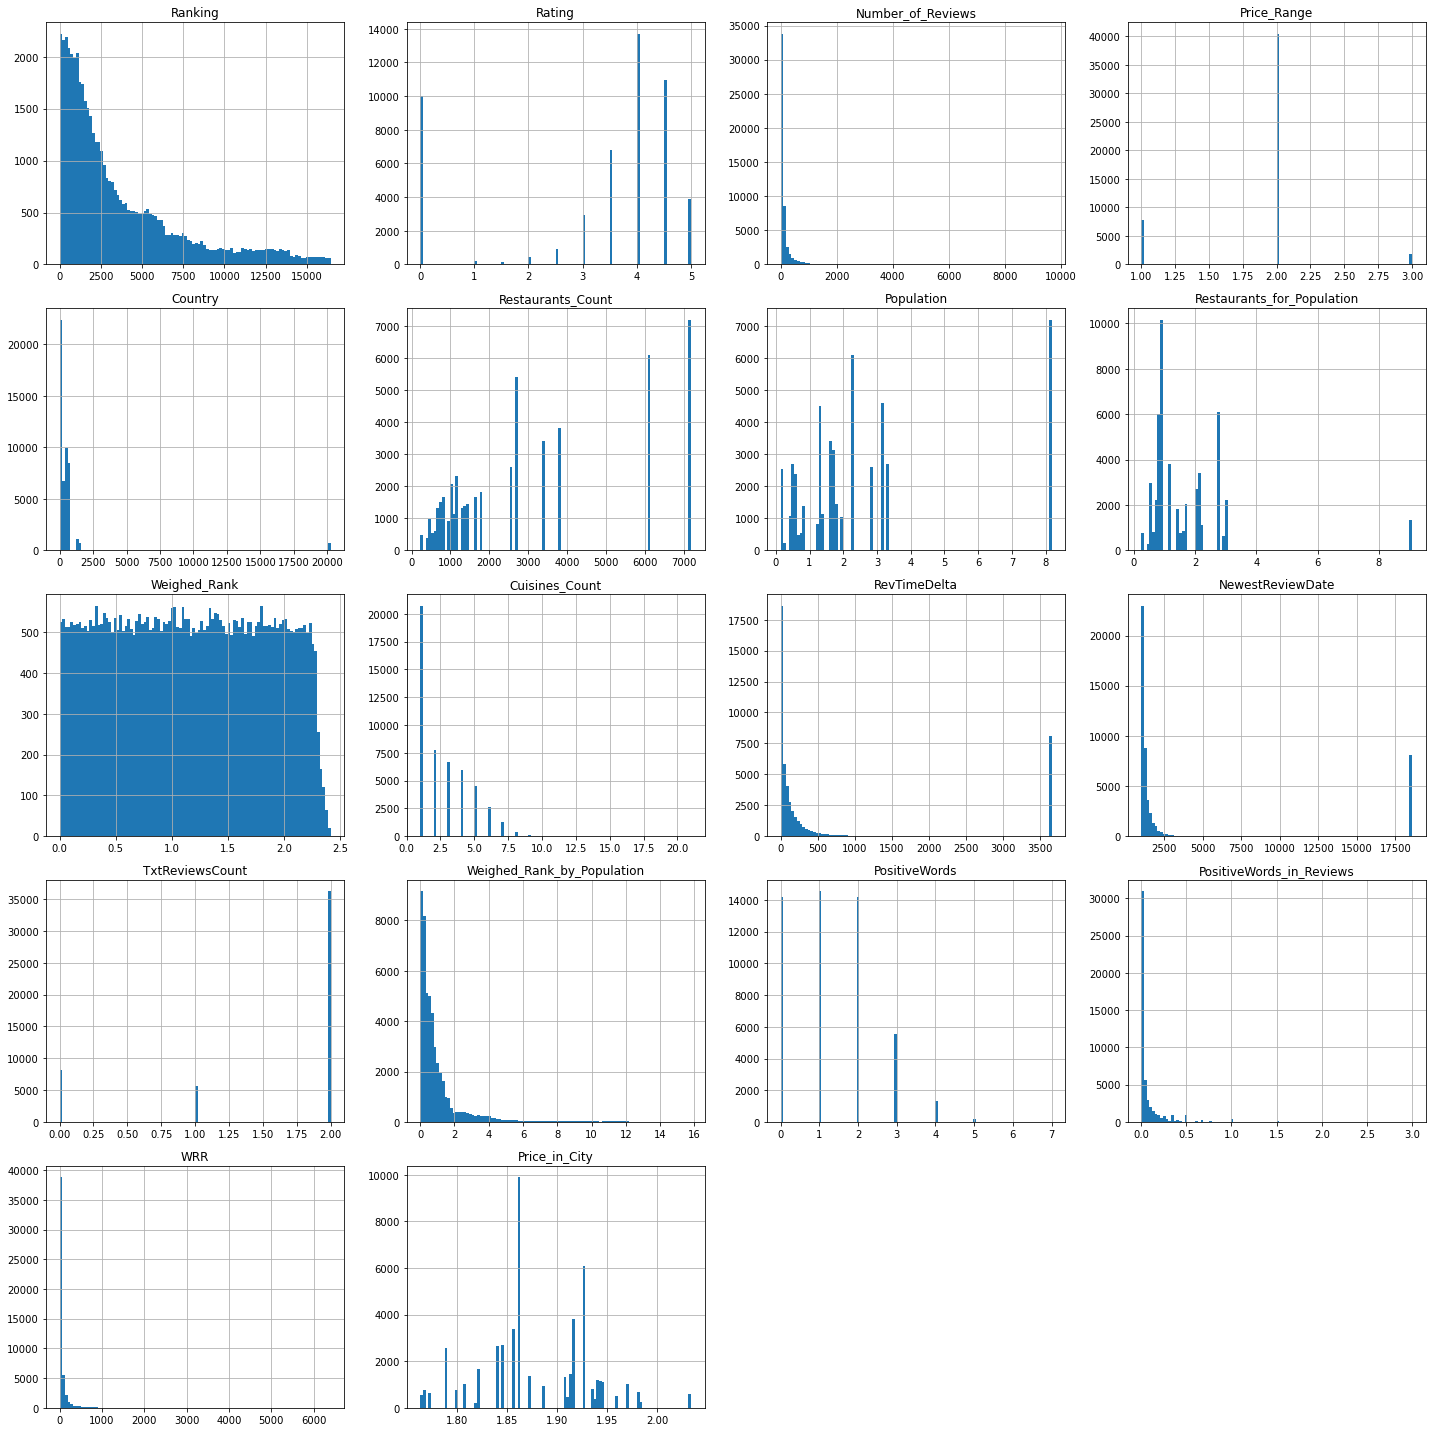

In [72]:
df[['Ranking', 'Rating', 'Number_of_Reviews', 'City', 'Price_Range',
        'Restaurant_id',  'Country',
       'Restaurants_Count', 'Population', 'Restaurants_for_Population',
       'Weighed_Rank',  'Cuisines_Count',
       'RevTimeDelta', 'NewestReviewDate',
       'TxtReviewsCount', 'Weighed_Rank_by_Population', 'PositiveWords','PositiveWords_in_Reviews',
        'WRR', 'Price_in_City', 'Restaurant_net_id']].hist(figsize=(20, 20), bins=100);
plt.tight_layout()

<AxesSubplot:>

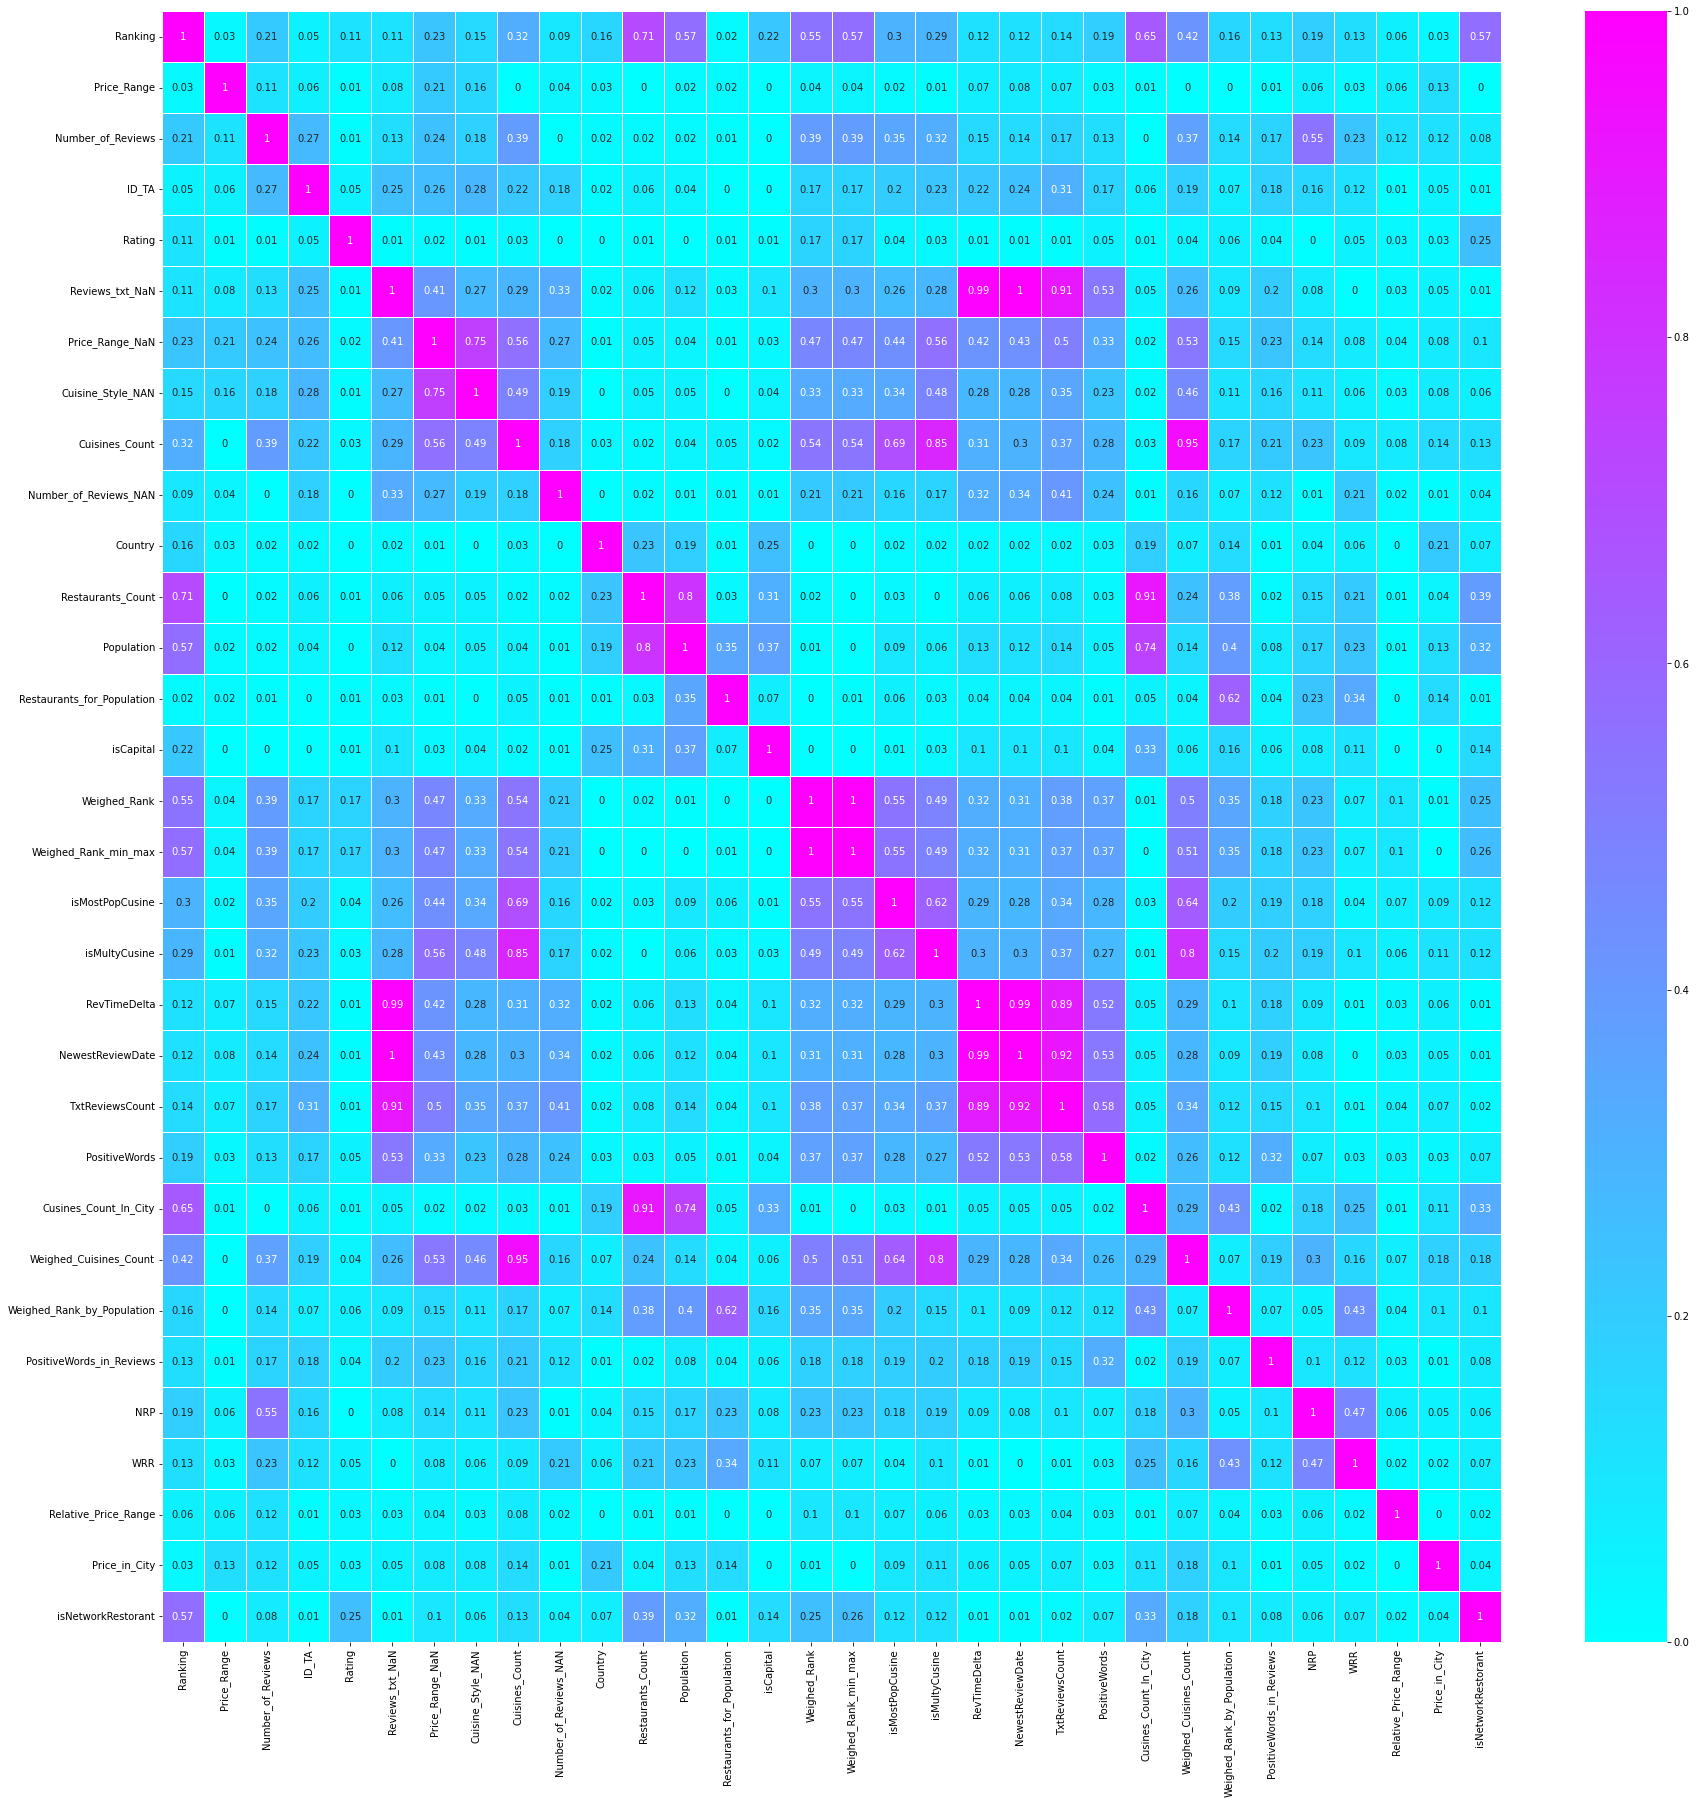

In [73]:
table_corr = abs(df.drop(['Train'],axis=1).corr().round(2))
plt.rcParams['figure.figsize'] = (30,30)
sns.heatmap(table_corr, vmin=0, vmax=1, cmap="cool", linewidths=1,annot=True)

## Собираем dummies

In [74]:
# Собираем Dummies: city, price_range, country_range, Cuisine top N

dff = pd.get_dummies(df['Cuisine_top_N'].apply(pd.Series).stack()).sum(level=0)
df_mcc = pd.get_dummies(df['Most_Common_Cusine_in_City'], prefix = 'MCC_')
df_city_dum = pd.get_dummies(df['City'], prefix = 'City_')
df_city_Top = pd.get_dummies(df['TopCityes'], prefix = 'City_Top', dummy_na=True)
df_price_range = pd.get_dummies(df['Price_Range'], prefix = 'Price_') 
df_country_range = pd.get_dummies(df['Country'], prefix = 'Country_') 
df_season_range = pd.get_dummies(df['NewestReviewSeason'], prefix = 'Season')

df['PositiveWordsList'] = df['PositiveWordsList'].fillna('PositiveWords_NAN')
df_positive_words_range = pd.get_dummies(df['PositiveWordsList'].apply(pd.Series).stack(), dummy_na=False).sum(level=0)

df1 = pd.concat([df,dff], axis=1)
df1 = pd.concat([df1,df_city_dum], axis=1)
df1 = pd.concat([df1,df_price_range], axis=1)
df1 = pd.concat([df1,df_country_range], axis=1)
df1 = pd.concat([df1,df_mcc], axis=1)
df1 = pd.concat([df1,df_positive_words_range], axis=1)

#df1 = pd.concat([df1,df_season_range], axis=1)

cols_cuisine_style = dff.columns
cols_city = df_city_dum.columns
cols_price_range =  df_price_range.columns
cols_country_range =  df_country_range.columns
cols_mcc =  df_mcc.columns
cols_positive_words = df_positive_words_range.columns
#cols_season = df_season_range.columns

In [75]:
# Собираем признаки И Разбиваем датафрейм на части, необходимые для обучения и тестирования модели
columns = [ 'isMultyCusine', 'Price_Range_NaN', 'Cuisine_Style_NAN', 'Number_of_Reviews_NAN', 'Number_of_Reviews',
     'Restaurants_Count', 'Cuisines_Count', 'RevTimeDelta', 'NewestReviewDate', 'PositiveWords',  'Weighed_Rank',
     'Ranking', 'Weighed_Rank_by_Population',  'Cusines_Count_In_City', 'WRR', 'ID_TA', 'Weighed_Rank_min_max',
     'Price_in_City', 'isCapital', 'Population', 'Restaurants_for_Population' ]

columns.extend(cols_price_range.tolist())
columns.extend(cols_cuisine_style.tolist())
columns.extend(cols_city.tolist())
columns.extend(cols_country_range.tolist())
columns.extend(cols_positive_words.tolist())

#Разбиваем датафрейм на части, необходимые для обучения и тестирования модели
X = df1[df1.Train][columns]

y = df1[df1.Train]['Rating']

# 9. Class

In [78]:
class preprocessor():
    def __init__(self, df_Train, df_Test, Sample_Submission):
        '''Функция инициализации'''
        self.df_train = df_Train
        self.df_test = df_Test
        self.sample_submission = Sample_Submission
        self.pos_words_list = df_pos_words[0].to_list()
        self.neg_words_list = df_neg_words[0].to_list()
        self.allCusines = []
        self.df_train['Train'] = True # помечаем где у нас трейн
        self.df_test['Train'] = False # помечаем где у нас тест
        self.df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями
        self.data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем
        self.data.columns = list(map(lambda x: x.replace(" ","_"), data.columns))
        self.df = data.drop('URL_TA',axis=1).copy()

    
    def get_df(self):
        '''Получить новый датасет'''
        return self.df

    def clean_and_fill(self):
        '''Очистить текущий датасет'''
        self.df['ID_TA'] = self.df['ID_TA'].apply(lambda x: x[1:]).astype(int)

        # Reviews - убираем NaN и "причесываем" текст отзывов 
        self.df['Reviews_txt_NaN'] = self.df['Reviews'].apply(lambda x: x ==  '[[], []]')
        self.df['Reviews'] = self.df['Reviews'].fillna('[[], []]')
        self.df['Reviews'] = self.df['Reviews'].apply(lambda x: cleanup_string(x))

        # Number of Reviews
        self.df['Number_of_Reviews_NAN'] = self.df['Number_of_Reviews'].isna()
        replace_val = df['Number_of_Reviews'].mean()
        replace_val = np.round(replace_val)
        self.df['Number_of_Reviews'] = self.df['Number_of_Reviews'].fillna(replace_val)

        # Перекодируем Price Range и удаляем NaN
        cleanup_nums = {'Price_Range': {"$": 1, "$$ - $$$": 2, "$$$$": 3, np.NaN: 2}}
        # чаще всего встречается "$$ - $$$", поэтому пропуски заменили на 2
        self.df['Price_Range_NaN'] = self.df['Price_Range'].isna()
        self.df.replace(cleanup_nums, inplace=True)

        # Получаем Cuisines Count, самую популярную кухню, среднее к-во кухонь в ресторане и устраняем NaN
        self.df['Cuisine_Style_NAN'] = self.df['Cuisine_Style'].isna()
        self.df['Cuisine_Style'] = self.df['Cuisine_Style'].fillna('NaN')
        self.df['Cuisines_Count'] = self.df.apply(cuisine_styles_count, axis=1)
        self.most_popular_cusine = pd.Series(allCusines).value_counts().index[0]
        self.average_cousines_count = np.round(df['Cuisines_Count'].mean())

    def feature_engineering(self):
        '''Добавить признаки в текущий датасет'''
        population_city_dict = {}
        country_city_dict = {}
        
        # Получаем словари популяции по городам, а так же ISO код страны по городу
        population_city_dict, country_city_dict = get_city_population_and_country(self.df, df_city)

        # Вычисляем страну для города в каждой строке
        self.df['Country'] = self.df["City"].apply(lambda x: country_city_dict[x])

        # Вычисляем к-во ресторанов для города в каждой строке
        restorants_in_city = self.df.groupby('City')['Ranking'].count().to_dict()
        self.df['Restaurants_Count'] = self.df['City'].map(restorants_in_city)

        # Вычисляем население (в тыс. чел) для города в каждой строке
        self.df['Population'] = self.df["City"].map(population_city_dict)

        # Вычисляем к-во ресторанов на 1000 чел для города в каждой строке
        self.df['Restaurants_for_Population'] = self.df.Restaurants_Count / (self.df['Population']*1000)

        # Вычисляем является ли город столицей в каждой строке
        capital_city_dict = get_capital_city_dict(self.df, df_city)
        self.df['isCapital'] = self.df["City"].apply(lambda x: capital_city_dict[x])

        # Получаем относительную позицию ресторана среди всех ресторанов города
        self.df['Weighed_Rank'] = self.df.apply(lambda x: get_Weighed_Rank_RK(x), axis=1)

        CityMinMax = self.df.groupby('City')['Ranking'].agg([min,max])
        CityMinMax = CityMinMax.reset_index()
        self.df['Weighed_Rank_min_max'] = self.df.apply(lambda x: get_Weighed_Rank(CityMinMax, x), axis=1)

        # Флаги (1/0) isMostPopCusine - есть ли в ресторане самая популярная кухня; isMultyCusine - к-во кухонь в ресторане больше или столько же чем в среднем
        self.df['isMostPopCusine'] = self.df.Cuisine_Style.apply(lambda x: 1 if self.most_popular_cusine in x else 0 )
        self.df['isMultyCusine'] = self.df.Cuisines_Count.apply(lambda x: 1 if  x >= self.average_cousines_count else 0 )

        # RevTimeDelta - время между review в днях
        self.df['RevTimeDelta'] = self.df.Reviews.apply(rev_time_delta)

        # NewestReviewDate - время, прошедшее со момента последнего review
        self.df['NewestReviewDate'] = self.df.Reviews.apply(lambda x: get_reviews(x)['reviews_dt'])
        self.df['NewestReviewDate'] = self.df.NewestReviewDate.apply(lambda x: sorted(x,reverse=True)[0] if len(x)!=0 else pd.NaT)
        self.df['NewestReviewDate'] = self.df.NewestReviewDate.fillna(dt.date(1970,1,1))
        self.df['NewestReviewDate'] = self.df.NewestReviewDate.apply(lambda x: (CURRENT_DATE.date()-x).total_seconds()//86400)

        self.df['NewestReviewSeason'] = self.df.Reviews.apply(lambda x: get_reviews(x)['reviews_dt'])
        self.df['NewestReviewSeason'] = self.df.NewestReviewSeason.apply(lambda x: sorted(x,reverse=True)[0] if len(x)!=0 else pd.NaT)
        self.df['NewestReviewSeason'] = self.df.NewestReviewSeason.apply(lambda x: get_season(x))

        #  'TxtReviewsCount' - к-во отзывов, не сильно улучшает результат, но пусть будут
        self.df['TxtReviewsCount'] = self.df.Reviews.apply(lambda x: len(get_reviews(x)['reviews_txt']))

        # К-во позитивных слов в представленных отзывах
        self.df['PositiveWords'] = self.df.Reviews.apply(lambda x: count_positive_words_proportion(x))
        # Список уникальных позитивных слов в представленных отзывах
        self.df['PositiveWordsList'] = self.df.Reviews.apply(lambda x: list_positive_words(x))
        self.df['PositiveWordsList'] = self.df['PositiveWordsList'].fillna('PositiveWords_NAN')
        self.df['PositiveWords_in_Reviews'] = self.df['PositiveWords'] / df['Number_of_Reviews']

        # К-во негативных слов в представленных отзывах
        self.df['NegativeWords'] = self.df.Reviews.apply(lambda x: count_negative_words_proportion(x))
        # Список уникальных негативных слов в представленных отзывах
        self.df['NegativeWordsList'] = self.df.Reviews.apply(lambda x: list_negative_words(x))
        self.df['NegativeWordsList'] = self.df['NegativeWordsList'].fillna('NegativeWords_NAN')
        self.df['NegativeWords_in_Reviews'] = self.df['NegativeWords'] / df['Number_of_Reviews']

        cusines_in_city={}
        cusines_count_in_city={}
        for city_name, group in self.df.groupby('City'):
            #Получим серию со списками кухонь для групп
            cusines = group['Cuisine_Style'].apply(get_cuisines)
            #Получим список кухонь в группе
            cusines_list = list(itertools.chain.from_iterable(cusines))
            #Посчитаем и запишем число совпадений для каждой кухни в каждой группе при помощи Counter
            cusines_in_city[city_name] = Counter(cusines_list)    
        for city_name in cusines_in_city.keys():
            cusines_count_in_city[city_name] = len(cusines_in_city[city_name])
        self.df['Cusines_Count_In_City'] = self.df.City.map(cusines_count_in_city)

        # Относительная доля кухонь в ресторане
        self.df['Weighed_Cuisines_Count'] = self.df['Cuisines_Count'] / self.df['Cusines_Count_In_City']  
        # Самая популярная кухня в городе
        self.df['Most_Common_Cusine_in_City'] = self.df['City'].apply(lambda x: cusines_in_city[x].most_common(1)[0][0])
        # Заменим пропуски на самую популярную
        self.df['Cuisine_Style'] = self.df.apply(lambda x: x['Cuisine_Style'] if x['Cuisine_Style_NAN'] ==False else [x['Most_Common_Cusine_in_City']], axis=1)

        # зависимость места ресторана в городе от населения
        self.df['Weighed_Rank_by_Population'] = self.df['Weighed_Rank']  / self.df['Population'] 


        # Как часто в городе оставляют отзывы
        self.df['NRP'] = self.df['Number_of_Reviews'] / self.df['Population']
        # Ранг ресторана с учетом частоты отзывов в городе
        self.df['WRR'] =  self.df['Weighed_Rank']  *  self.df['NRP'] 

        self.df['Relative_Price_Range'] = self.df['Price_Range'] / self.df['Weighed_Rank']

        # Средняя цена в городе
        price_in_city_dict = self.df.groupby('City')['Price_Range'].mean().to_dict()
        self.df['Price_in_City'] = self.df['City'].map(price_in_city_dict)

        # Сокращаем список кухонь для анализа до N - основных, остальные Other
        N=30 #!!!

        s = self.df['Cuisine_Style'].apply(lambda x: get_cuisines(x))
        slist =[]
        for x in s:
            slist.extend(x)
        self.topNcusines = set(pd.Series(slist).value_counts()[:N].index)  
        self.df['Cuisine_top_N'] =self.df['Cuisine_Style'].apply(lambda x: is_cuisine_top_N(x))



        # Сетевой ID ресторана (похоже, что это ID франшизы, если повторяется более 1-го раза - isNetworkRestorant)
        import warnings; warnings.simplefilter('ignore')
        self.df['Restaurant_net_id'] = self.df['Restaurant_id'].apply(lambda x: x.split('_')[1])
        NetworkRestorants = self.df[self.df['Restaurant_net_id'].isin(self.df['Restaurant_net_id'].value_counts()[self.df['Restaurant_net_id'].value_counts()>2].index)]
        NetworkRestorants['isNetworkRestorant'] = True
        self.df['isNetworkRestorant'] = NetworkRestorants['isNetworkRestorant']
        self.df['isNetworkRestorant'] = self.df['isNetworkRestorant'].fillna(False)

        # Помечаем, входит ли город в N-top городов, если ДА, то пишем его назавние, если НЕТ -Other
        top_Cityes = self.df['City'].value_counts()[0:10].index.to_list()
        self.df['TopCityes'] = self.df.City.apply(lambda x: x if x in top_Cityes else 'Other_City')
    
    def dummies(self):
        '''Добавить dummies в текущий датасет'''

        df_Cuisine_top_N = pd.get_dummies(self.df['Cuisine_top_N'].apply(pd.Series).stack()).sum(level=0)
        df_mcc = pd.get_dummies(self.df['Most_Common_Cusine_in_City'], prefix = 'MCC')
        df_city_dum = pd.get_dummies(self.df['City'], prefix = 'City')
        df_price = pd.get_dummies(self.df['Price_Range'], prefix = 'Price') 
        df_country = pd.get_dummies(self.df['Country'], prefix = 'Country') 
        df_season = pd.get_dummies(df['NewestReviewSeason'], prefix = 'Season')
        df_positive_words = pd.get_dummies(self.df['PositiveWordsList'].apply(pd.Series).stack(), dummy_na=False).sum(level=0)
        df_negative_words = pd.get_dummies(self.df['NegativeWordsList'].apply(pd.Series).stack(), dummy_na=False).sum(level=0)


        #object_columns = []
        #for s in (self.df.columns):
        #    if self.df[s].dtypes == 'object':
        #        object_columns.append(s)
        #        print(s, self.df[s].dtypes)
        #object_columns = [s for s in self.df.columns if (self.df[s].dtypes == 'object')]

        self.df = pd.concat([self.df, df_Cuisine_top_N], axis=1)
        self.df = pd.concat([self.df, df_city_dum], axis=1)
        self.df = pd.concat([self.df, df_price], axis=1)
        self.df = pd.concat([self.df, df_country], axis=1)
        self.df = pd.concat([self.df, df_mcc], axis=1)
        self.df = pd.concat([self.df, df_positive_words], axis=1)
        self.df = pd.concat([self.df, df_negative_words], axis=1)
        self.df = pd.concat([self.df, df_season], axis=1)

        self.cols_cuisine_style = df_Cuisine_top_N.columns
        self.cols_city = df_city_dum.columns
        self.cols_price =  df_price.columns
        self.cols_country =  df_country.columns
        self.cols_mcc =  df_mcc.columns
        self.cols_positive_words = df_positive_words.columns
        self.cols_negative_words = df_negative_words.columns
        self.cols_season = df_season.columns
      
        #object_columns = self.df.dtypes[self.df.dtypes == 'object'].keys()
        #self.df.drop(object_columns, axis = 1, inplace=True)

        # Собираем признаки И Разбиваем датафрейм на части, необходимые для обучения и тестирования модели
        self.columns = [ 'isMultyCusine', 'Price_Range_NaN', 'Cuisine_Style_NAN', 'Number_of_Reviews_NAN', 'Number_of_Reviews',
             'Restaurants_Count', 'Cuisines_Count', 'RevTimeDelta', 'NewestReviewDate', 'PositiveWords',  'Weighed_Rank',
             'Ranking', 'Weighed_Rank_by_Population',  'Cusines_Count_In_City', 'WRR', 'ID_TA', 'Weighed_Rank_min_max',
             'Price_in_City', 'isCapital', 'Population', 'Restaurants_for_Population', 
             'Reviews_txt_NaN','isMostPopCusine', 'TxtReviewsCount', 'NegativeWords', 'NegativeWords_in_Reviews', 'PositiveWords_in_Reviews',
             'Weighed_Cuisines_Count', 'Relative_Price_Range',  'isNetworkRestorant' ]
        
        self.columns.extend(self.cols_price.tolist())
        self.columns.extend(self.cols_cuisine_style.tolist())
        self.columns.extend(self.cols_city.tolist())
        self.columns.extend(self.cols_country.tolist())
        self.columns.extend(self.cols_mcc.tolist())
        self.columns.extend(self.cols_positive_words.tolist())
        self.columns.extend(self.cols_negative_words.tolist())
        self.columns.extend(self.cols_season.tolist())

    def Run(self):
        '''Выполнить все действия'''
        self.clean_and_fill()
        self.feature_engineering()
        self.dummies()
    
    def get_X_y(self):
        '''Разбиваем датафрейм на части, необходимые для обучения и тестирования модели'''
        X = self.df[self.df.Train][self.columns]
        y = self.df[self.df.Train]['Rating']
        return (X,y)

    def get_columns(self):
        '''Вернуть колонки'''
        return self.columns

In [79]:
prepro = preprocessor(df_train, df_test, sample_submission)
prepro.Run()
df1 = prepro.get_df()
X, y = prepro.get_X_y()
columns = prepro.columns

In [81]:
x_cols = set(X.columns)
f_cols = set(df1.columns)
f_cols - x_cols

{'City',
 'Country',
 'Cuisine_Style',
 'Cuisine_top_N',
 'Most_Common_Cusine_in_City',
 'NRP',
 'NegativeWordsList',
 'NewestReviewSeason',
 'PositiveWordsList',
 'Price_Range',
 'Rating',
 'Restaurant_id',
 'Restaurant_net_id',
 'Reviews',
 'TopCityes',
 'Train'}

# 10. Model 

In [83]:
# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.
# Для тестирования мы будем использовать 20% от исходного датасета.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
regr = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

# Обучаем модель на тестовом наборе данных
regr.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = regr.predict(X_test)
y_pred_old = y_pred.copy()
y_pred = round_of_rating(y_pred) 

# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE с округлением:', metrics.mean_absolute_error(y_test, y_pred), 'MAE без округления:', metrics.mean_absolute_error(y_test, y_pred_old) )

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   17.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   46.8s finished


MAE с округлением: 0.1589375 MAE без округления: 0.19134125


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


<AxesSubplot:>

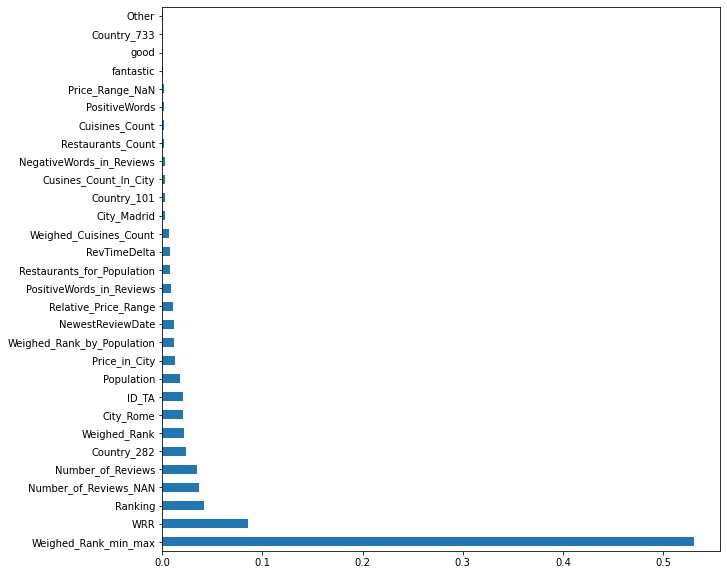

In [86]:
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(regr.feature_importances_, index=X.columns)
feat_importances.nlargest(30).plot(kind='barh')

# 11. Submission

In [88]:
# Предсказываем рейтинги на датасете для предсказаний (Train == False)
X_submission = df1[df1.Train == False][columns]
y_pred_submission = round_of_rating(regr.predict(X_submission))

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


In [89]:
# Формируем датасет с предсказаниями Restaurant_id -- Rating
submission_df = pd.DataFrame()
submission_df['Restaurant_id'] = df1[df1.Train == False]['Restaurant_id']
submission_df['Rating'] = y_pred_submission
submission_df.head(15)

,Restaurant_id,Rating
0,id_0,3.0
1,id_1,4.5
2,id_2,4.5
3,id_3,4.5
4,id_4,4.5
5,id_5,4.5
6,id_6,2.0
7,id_7,3.0
8,id_8,4.5
9,id_9,4.5


In [90]:
print('Тренировочный датасет')
df[df.Train].Rating.value_counts()

Тренировочный датасет


4.0    13692
4.5    10929
3.5     6824
5.0     3879
3.0     2955
2.5      915
2.0      466
1.0      201
1.5      139
Name: Rating, dtype: int64

In [91]:
print('Предсказания масштабированные в 4 раза')
submission_df.Rating.value_counts()*4

Предсказания масштабированные в 4 раза


4.0    15240
4.5    10960
3.5     6440
3.0     3020
5.0     2956
2.5      716
2.0      392
1.0      184
1.5       92
Name: Rating, dtype: int64

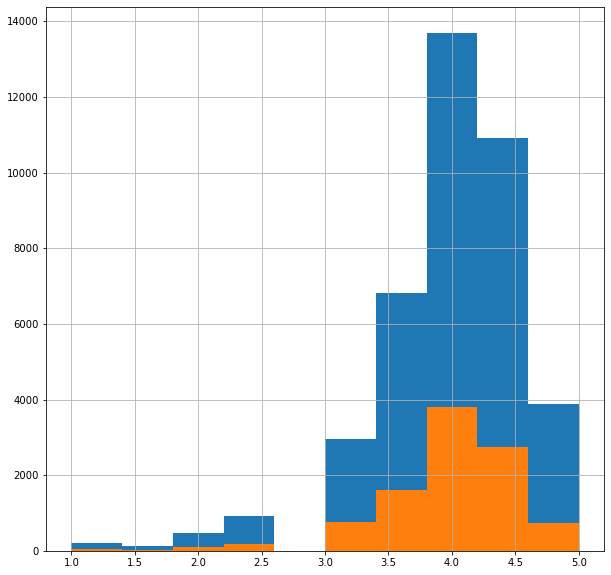

In [92]:
h = df[df.Train].Rating.hist()
f = submission_df.Rating.hist()
fig = h.get_figure()
fig = f.get_figure()

In [93]:
# Распределения достаточно похожи - ОК!
# Сохраняем предсказания
submission_df.to_csv('submission.csv', index=False)